<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Datos
El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
def sequence_acc(y_pred_logits, y_true_idx):
    # 1) Predicción token a token
    y_pred_tags = y_pred_logits.argmax(dim=-1)  # [batch, seq_len]
    # 2) Comparar
    correct = (y_pred_tags == y_true_idx).float()  # [batch, seq_len]
    # 3) Accuracy global
    return correct.mean()  # escalar

def train(model,
          train_loader,
          valid_loader,
          optimizer,
          criterion,
          epochs=100,
          patience=5,
          min_delta=1e-4,
          device='cuda'):
    # 1) Llevar modelo a device
    model = model.to(device)

    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []

    best_val_loss = float('inf')
    patience_ctr = 0
    best_state = None

    for epoch in range(1, epochs+1):
        # --- Entrenamiento ---
        model.train()
        running_loss, running_acc = 0.0, 0.0

        for enc_in, dec_in, target in train_loader:
            # 2) Datos al device y cast a long
            enc_in = enc_in.to(device).long()
            dec_in = dec_in.to(device).long()

            # Si target viene one-hot (3D), convertimos a índices 2D
            if target.dim() == 3:
                target_idx = target.argmax(dim=-1).to(device)
            else:
                target_idx = target.to(device).long()

            optimizer.zero_grad()

            # 3) Forward
            logits = model(enc_in, dec_in)  # [B, L, V]

            # 4) Vectorizar loss
            B, L, V = logits.shape
            logits_flat = logits.view(-1, V)            # [B*L, V]
            target_flat = target_idx.view(-1)           # [B*L]

            loss = criterion(logits_flat, target_flat)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += sequence_acc(logits, target_idx).item()

        avg_train_loss = running_loss / len(train_loader)
        avg_train_acc  = running_acc  / len(train_loader)
        train_loss.append(avg_train_loss)
        train_acc .append(avg_train_acc)

        # --- Validación Completa ---
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for enc_in, dec_in, target in valid_loader:
                enc_in = enc_in.to(device).long()
                dec_in = dec_in.to(device).long()
                if target.dim() == 3:
                    target_idx = target.argmax(dim=-1).to(device)
                else:
                    target_idx = target.to(device).long()

                logits = model(enc_in, dec_in)
                B, L, V = logits.shape
                logits_flat = logits.view(-1, V)
                target_flat = target_idx.view(-1)

                loss = criterion(logits_flat, target_flat)
                val_loss += loss.item()
                val_acc  += sequence_acc(logits, target_idx).item()

        avg_val_loss = val_loss / len(valid_loader)
        avg_val_acc  = val_acc  / len(valid_loader)
        valid_loss.append(avg_val_loss)
        valid_acc .append(avg_val_acc)

        print(f"Epoch {epoch}/{epochs} — "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

        # --- Early Stopping ---
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            patience_ctr = 0
            best_state   = model.state_dict()
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break

    # 5) Restaurar mejor modelo
    if best_state is not None:
        model.load_state_dict(best_state)

    history = {
        "loss": train_loss,
        "accuracy": train_acc,
        "val_loss": valid_loss,
        "val_accuracy": valid_acc,
    }
    return history, model


### 1 - Datos

In [3]:
# dataset_file

text_file = "./clase/spa-eng/spa.txt"
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 25000

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

if MAX_NUM_SENTENCES == 0:
    MAX_NUM_SENTENCES = len(lines)
for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 25000


In [4]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [5]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 30000

In [6]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from clase.torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 7515
Sentencia de entrada más larga: 32


In [7]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 12709
Sentencia de salida más larga: 36


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [8]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 20#30#50
max_out_len = 22#30#54

A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [9]:
from clase.torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 25000
encoder_input_sequences shape: (25000, 20)
decoder_input_sequences shape: (25000, 22)


In [10]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (25000, 22)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategía que se transformó la entrada del decoder.

In [11]:
torch.from_numpy(decoder_output_sequences).shape

torch.Size([25000, 22])

In [12]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 20
decoder_input_size: 22
Output dim 12710


In [13]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

Tamaño del conjunto de entrenamiento: 20000
Tamaño del conjunto de validacion: 5000


### 3 - Preparar los embeddings

In [14]:
from gensim.models.fasttext import load_facebook_vectors
model_embeddings = load_facebook_vectors("clase/cc.en.300.bin")  
from gensim.models.fasttext import load_facebook_vectors
model_embeddings_es = load_facebook_vectors("clase/cc.es.300.bin")

In [15]:
vocab_size_in  = max(word2idx_inputs .values()) + 1   
vocab_size_out = max(word2idx_outputs.values()) + 1   
embed_dim = 300
# Inglés
embedding_matrix = np.zeros((vocab_size_in, embed_dim), dtype=np.float32)
for w, idx in word2idx_inputs.items():
    # idx incluye todos los valores hasta max_index
    if w in model_embeddings:
        embedding_matrix[idx] = model_embeddings[w]
# Español
embedding_matrix_es = np.zeros((vocab_size_out, embed_dim), dtype=np.float32)
for w, idx in word2idx_outputs.items():
    if w in model_embeddings_es:
        embedding_matrix_es[idx] = model_embeddings_es[w]
print(embedding_matrix.shape)
print(embedding_matrix_es.shape)
nb_words = embedding_matrix.shape[0]
num_words_output = embedding_matrix_es.shape[0]

(7516, 300)
(12710, 300)


### 4 - Entrenar el modelo

In [23]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = False  # Opcional: Freezar

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=encoder_input.device)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            input = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input, prev_state)
            # top1 = output.argmax(1).view(-1, 1)
            top1 = output[:, -1, :].argmax(1).view(-1, 1)
            # guardar cada salida (softmax)
            outputs[:, t, :] = output.squeeze(1)
            # outputs[:, t, :] = output

        return outputs

In [24]:
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 22, 12710]            --
├─Encoder: 1-1                           [2, 1, 256]               --
│    └─Embedding: 2-1                    [1, 20, 300]              (2,254,800)
│    └─LSTM: 2-2                         [1, 20, 256]              1,097,728
├─Decoder: 1-2                           [1, 1, 12710]             --
│    └─Embedding: 2-3                    [1, 1, 300]               (3,813,000)
│    └─LSTM: 2-4                         [1, 1, 256]               1,097,728
│    └─Linear: 2-5                       [1, 1, 12710]             3,266,470
├─Decoder: 1-3                           [1, 1, 12710]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 256]               (recursive)
│    └─Linear: 2-8                       [1, 1, 12710]             (recursive)
├─Decoder:

In [25]:
history1, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )

Epoch 1/100 — Train Loss: 6.1560, Acc: 0.0553 | Val Loss: 5.4990, Acc: 0.0624
Epoch 2/100 — Train Loss: 5.1015, Acc: 0.0663 | Val Loss: 5.1227, Acc: 0.0694
Epoch 3/100 — Train Loss: 4.6584, Acc: 0.0731 | Val Loss: 4.9633, Acc: 0.0756
Epoch 4/100 — Train Loss: 4.3245, Acc: 0.0792 | Val Loss: 4.8347, Acc: 0.0828
Epoch 5/100 — Train Loss: 4.0226, Acc: 0.0857 | Val Loss: 4.7857, Acc: 0.0854
Epoch 6/100 — Train Loss: 3.7837, Acc: 0.0899 | Val Loss: 4.8427, Acc: 0.0867
Epoch 7/100 — Train Loss: 3.5691, Acc: 0.0948 | Val Loss: 4.8894, Acc: 0.0864
Epoch 8/100 — Train Loss: 3.3761, Acc: 0.1012 | Val Loss: 4.9356, Acc: 0.0893
Epoch 9/100 — Train Loss: 3.1953, Acc: 0.1086 | Val Loss: 4.9791, Acc: 0.0885
Epoch 10/100 — Train Loss: 3.0399, Acc: 0.1154 | Val Loss: 5.0716, Acc: 0.0915
Epoch 11/100 — Train Loss: 2.9004, Acc: 0.1225 | Val Loss: 5.1489, Acc: 0.0900
Epoch 12/100 — Train Loss: 2.7736, Acc: 0.1289 | Val Loss: 5.1967, Acc: 0.0908
Epoch 13/100 — Train Loss: 2.6619, Acc: 0.1349 | Val Loss: 5.

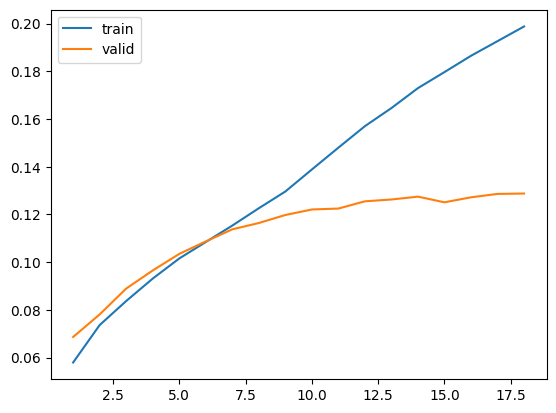

In [ ]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [26]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [27]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [28]:
def translate_sentence(input_text, 
                       model, 
                       input_tokenizer, 
                       word2idx_outputs, 
                       idx2word_target,
                       max_input_len,
                       max_output_len,
                       device):
    model.eval()
    
    # 1) Tokenizar y paddear
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post')
    
    encoder_input = torch.tensor(seq, dtype=torch.long).to(device)      # [1, max_input_len]
    # 2) Pasar por el encoder
    prev_state = model.encoder(encoder_input)                           # (h, c)
    
    # 3) Iniciar decoder con <sos>
    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    decoder_input = torch.tensor([[sos]], dtype=torch.long).to(device)  # [1, 1]
    
    output_words = []
    # 4) Loop hasta max_output_len o hasta <eos>
    for _ in range(max_output_len):
        logits, prev_state = model.decoder(decoder_input, prev_state)
        # logits: [1, 1, vocab_size]
        
        logits = logits.squeeze(1)           # [1, vocab_size]
        topi = logits.argmax(dim=1)          # [1]
        idx = topi.item()                    # entero
        
        if idx == eos:
            break
        output_words.append(idx2word_target[idx])
        
        # re-alimentar al decoder
        decoder_input = topi.unsqueeze(1)    # [1, 1]
    
    return ' '.join(output_words)



In [30]:
input_test = "My mother say hi."
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,  
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    My mother say hi.
Output:   tom se paró a la sombra y se acostó y se raspó y se raspó y se raspó


In [44]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Summer has just begun.
Output:   el niño se puso roja


In [45]:
import torch
import math
from copy import deepcopy

def translate_beam_search(
    input_text: str,
    model: Seq2Seq,
    input_tokenizer,
    word2idx_outputs: dict,
    idx2word_target: dict,
    max_input_len: int,
    max_output_len: int,
    device: torch.device,
    beam_width: int = 3,
):

    model.eval()

    # 1) Prepara encoder input
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post')
    encoder_input = torch.tensor(seq, dtype=torch.long).to(device)
    prev_state = model.encoder(encoder_input)  # (h, c)

    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']

    # Cada hipótesis es (tokens: List[int], state, score: float)
    hypotheses = [([sos], prev_state, 0.0)]

    for _ in range(max_output_len):
        all_candidates = []

        # Extender cada hipótesis
        for tokens, state, score in hypotheses:
            last_token = torch.tensor([[tokens[-1]]], dtype=torch.long).to(device)
            logits, new_state = model.decoder(last_token, state)  # [1,1,V]
            log_probs = torch.log_softmax(logits.squeeze(1), dim=-1)  # [1, V]
            topk_logps, topk_idxs = log_probs.topk(beam_width, dim=-1)

            for logp, idx in zip(topk_logps[0], topk_idxs[0]):
                new_tokens = tokens + [idx.item()]
                new_score  = score + logp.item()
                all_candidates.append((new_tokens, new_state, new_score))

        # Ordenar y quedarnos con beam_width mejores
        ordered = sorted(all_candidates, key=lambda tup: tup[2], reverse=True)
        hypotheses = ordered[:beam_width]

        # Si todas terminan en <eos>, interrumpir
        if all(h[0][-1] == eos for h in hypotheses):
            break

    # Elegir la hipótesis con mayor score que termine en <eos> (o la mejor si ninguna termina)
    best = None
    for tokens, state, score in hypotheses:
        if tokens[-1] == eos:
            best = (tokens, score)
            break
    if best is None:
        best = (hypotheses[0][0], hypotheses[0][2])

    # Convertir ids a palabras, quitando <sos> y todo lo que venga tras <eos>
    best_tokens = best[0]
    words = []
    for idx in best_tokens:
        if idx == sos:
            continue
        if idx == eos:
            break
        words.append(idx2word_target.get(idx, '<unk>'))

    return ' '.join(words)


In [53]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_beam_search(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,
    device=device,
    beam_width=5  
)
print("Input: ", input_test)
print("Output:", translation)


Input:  Leave the room.
Output: ella se levantó y caminó en el banco


---------

#### Sin filtrar padding en crossEntropy

Epoch 1/100 — Train Loss: 1.4052, Acc: 0.7717 | Val Loss: 1.7177, Acc: 0.7673
Epoch 2/100 — Train Loss: 0.7547, Acc: 0.8331 | Val Loss: 1.7235, Acc: 0.7718
Epoch 3/100 — Train Loss: 0.7102, Acc: 0.8416 | Val Loss: 1.7695, Acc: 0.7733
Epoch 4/100 — Train Loss: 0.6765, Acc: 0.8478 | Val Loss: 1.7907, Acc: 0.7736
Epoch 5/100 — Train Loss: 0.6474, Acc: 0.8527 | Val Loss: 1.7971, Acc: 0.7769
Epoch 6/100 — Train Loss: 0.6218, Acc: 0.8571 | Val Loss: 1.8247, Acc: 0.7765
Epoch 7/100 — Train Loss: 0.5984, Acc: 0.8606 | Val Loss: 1.8541, Acc: 0.7770
Epoch 8/100 — Train Loss: 0.5771, Acc: 0.8641 | Val Loss: 1.8570, Acc: 0.7804
Epoch 9/100 — Train Loss: 0.5599, Acc: 0.8665 | Val Loss: 1.8707, Acc: 0.7815
Epoch 10/100 — Train Loss: 0.5416, Acc: 0.8699 | Val Loss: 1.8912, Acc: 0.7819
Epoch 11/100 — Train Loss: 0.5274, Acc: 0.8719 | Val Loss: 1.9047, Acc: 0.7816

Early stopping at epoch 11


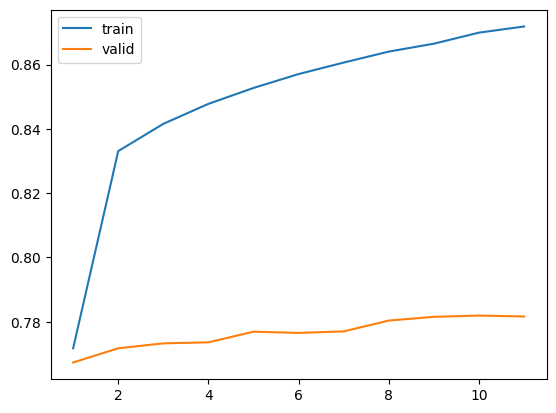

In [54]:
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
history2, model2 = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history2['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history2['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_accuracy'], label='valid')
plt.show()

In [55]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model2,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Tom was struck by lightning.
Output:   tom se quitó la mano y se comió toda la noche y se echó a un amigo de vuelta


---------------

## Pruebas con mas datos

In [5]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

text_file = "./clase/spa-eng/spa.txt"
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 0

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

if MAX_NUM_SENTENCES == 0:
    MAX_NUM_SENTENCES = len(lines)
for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)


In [9]:
from clase.torch_helpers import Tokenizer
from clase.torch_helpers import pad_sequences

MAX_VOCAB_SIZE = 30000
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)
print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))
print("Cantidad de rows del dataset:", len(input_integer_seq))
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Palabras en el vocabulario: 13524
Sentencia de entrada más larga: 47
Palabras en el vocabulario: 26341
Sentencia de salida más larga: 50
Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964
Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 47)
decoder_input_sequences shape: (118964, 50)


In [11]:
from gensim.models.fasttext import load_facebook_vectors
model_embeddings = load_facebook_vectors("clase/cc.en.300.bin")  
from gensim.models.fasttext import load_facebook_vectors
model_embeddings_es = load_facebook_vectors("clase/cc.es.300.bin")

In [16]:
vocab_size_in  = max(word2idx_inputs .values()) + 1   
vocab_size_out = max(word2idx_outputs.values()) + 1   
embed_dim = 300
# Inglés
embedding_matrix = np.zeros((vocab_size_in, embed_dim), dtype=np.float32)
for w, idx in word2idx_inputs.items():
    # idx incluye todos los valores hasta max_index
    if w in model_embeddings:
        embedding_matrix[idx] = model_embeddings[w]
# Español
embedding_matrix_es = np.zeros((vocab_size_out, embed_dim), dtype=np.float32)
for w, idx in word2idx_outputs.items():
    if w in model_embeddings_es:
        embedding_matrix_es[idx] = model_embeddings_es[w]
print(embedding_matrix.shape)
print(embedding_matrix_es.shape)
nb_words = embedding_matrix.shape[0]
num_words_output = embedding_matrix_es.shape[0]

(13525, 300)
(26342, 300)


In [23]:
from clase.torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 20)
decoder_input_sequences shape: (118964, 22)
decoder_output_sequences shape: (118964, 22)


In [17]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

class Data(Dataset):
    def __init__(self, enc_in, dec_in, dec_out, num_words_output):
        self.encoder_inputs = torch.from_numpy(enc_in.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(dec_in.astype(np.int32))
        # one-hot de salida
        self.decoder_outputs = F.one_hot(
            torch.from_numpy(dec_out).to(torch.int64),
            num_classes=num_words_output
        ).float()
        self.len = self.encoder_inputs.shape[0]

    def __getitem__(self, idx):
        return (
            self.encoder_inputs[idx],
            self.decoder_inputs[idx],
            self.decoder_outputs[idx]
        )

    def __len__(self):
        return self.len


def train_on_chunks(
    model,
    encoder_input_sequences,   # numpy array (N, T_enc)
    decoder_input_sequences,   # numpy array (N, T_dec)
    decoder_output_sequences,  # numpy array (N, T_dec) with indices
    num_words_output,
    optimizer,
    criterion,
    chunk_size=2000,
    batch_size=128,
    device='cuda',
    **train_kwargs
):
    model = model.to(device)
    N = encoder_input_sequences.shape[0]

    # Creamos valid set una sola vez (p.ej. los últimos 20%)
    valid_split = int(0.9 * N)
    valid_enc = encoder_input_sequences[valid_split:]
    valid_dec = decoder_input_sequences[valid_split:]
    valid_out = decoder_output_sequences[valid_split:]
    valid_ds = Data(valid_enc, valid_dec, valid_out, num_words_output)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

    histories = []
    for start in range(0, valid_split, chunk_size):
        end = min(start + chunk_size, valid_split)

        # 1) Extraer numpy arrays del chunk
        chunk_enc = encoder_input_sequences[start:end]
        chunk_dec_in = decoder_input_sequences[start:end]
        chunk_dec_out = decoder_output_sequences[start:end]

        # 2) Instanciar Data y DataLoader
        train_ds = Data(chunk_enc, chunk_dec_in, chunk_dec_out, num_words_output)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

        print(f"\n=== Entrenando chunk {start}:{end} size={len(train_ds)} ===")
        history, _ = train(
            model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            **train_kwargs
        )
        histories.append(history)

    return model, histories

encoder = Encoder(vocab_size=nb_words)
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
Seq2Seq  = Seq2Seq(encoder, decoder)

In [24]:
optimizer = torch.optim.Adam(Seq2Seq.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
model, histories = train_on_chunks(
    Seq2Seq,
    encoder_input_sequences,
    decoder_input_sequences,
    decoder_output_sequences,
    num_words_output,
    optimizer=optimizer,
    criterion=criterion,
    chunk_size=8000,
    batch_size=128,
    device=device,
    epochs=100,       
    patience=8,
    min_delta=1e-4
)


=== Entrenando chunk 0:8000 size=8000 ===
Epoch 1/100 — Train Loss: 6.6163, Acc: 0.0508 | Val Loss: 6.1816, Acc: 0.0523
Epoch 2/100 — Train Loss: 5.8138, Acc: 0.0543 | Val Loss: 5.9654, Acc: 0.0580
Epoch 3/100 — Train Loss: 5.4586, Acc: 0.0593 | Val Loss: 5.7394, Acc: 0.0598
Epoch 4/100 — Train Loss: 5.1867, Acc: 0.0616 | Val Loss: 5.6812, Acc: 0.0616
Epoch 5/100 — Train Loss: 4.9988, Acc: 0.0635 | Val Loss: 5.6151, Acc: 0.0644
Epoch 6/100 — Train Loss: 4.8554, Acc: 0.0653 | Val Loss: 5.6049, Acc: 0.0656
Epoch 7/100 — Train Loss: 4.7193, Acc: 0.0674 | Val Loss: 5.6060, Acc: 0.0659
Epoch 8/100 — Train Loss: 4.5980, Acc: 0.0688 | Val Loss: 5.5876, Acc: 0.0672
Epoch 9/100 — Train Loss: 4.4804, Acc: 0.0703 | Val Loss: 5.5390, Acc: 0.0685
Epoch 10/100 — Train Loss: 4.3591, Acc: 0.0719 | Val Loss: 5.5492, Acc: 0.0700
Epoch 11/100 — Train Loss: 4.2468, Acc: 0.0734 | Val Loss: 5.5397, Acc: 0.0712
Epoch 12/100 — Train Loss: 4.1295, Acc: 0.0752 | Val Loss: 5.5571, Acc: 0.0713
Epoch 13/100 — Tra

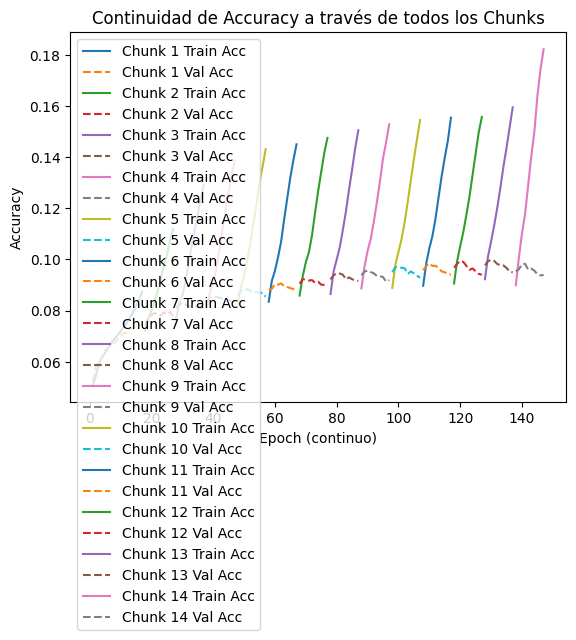

In [25]:
plt.figure()
epoch_offset = 0
for i, h in enumerate(histories):
    num_epochs = len(h['accuracy'])
    # X continuo para este chunk
    epochs = range(epoch_offset + 1, epoch_offset + num_epochs + 1)
    plt.plot(epochs, h['accuracy'], label=f'Chunk {i+1} Train Acc')
    plt.plot(epochs, h['val_accuracy'], linestyle='--', label=f'Chunk {i+1} Val Acc')
    epoch_offset += num_epochs

plt.xlabel('Epoch (continuo)')
plt.ylabel('Accuracy')
plt.title('Continuidad de Accuracy a través de todos los Chunks')
plt.legend()
plt.show()

In [26]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [31]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,  
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Tom is sleeping, isn't he?
Output:   tom no es la persona sabia


# Notas

- Se probó con redes más chicas de una capa, dos y tres. 
- Ampliando el estado oculto, con y sin dropout. 
- Sin filtrar le token de padding en el crossEntropy, el modelo daba mucho mejor accuracy, pero traducia muy mal. 
- Filtrando el padding, el accuracy da extremadamente bajo y sigue traduciendo igual de mal.